In [9]:
import copy
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pprint
from scipy.optimize import linprog

from mex.simplex.simplex_networks import create_matrix, pivots_col, pivots_row, find_negative_col, find_negative_row, find_pivot_col, find_pivot_row, pivot
from mex.simplex.problem_definition import add_cons, constrain, add_obj, obj, maxz, minz

#os.chdir("..")

## Problema prototipo:
(De las notas del Libro de Optimización)

$$\max_{x \in \mathbb{R}^2} 3x_1 + 5x_2$$

$$\text{sujeto a: }$$
$$x_1 \leq 4$$
$$2x_2 \leq 12$$
$$3x_1 + 2x_2 \leq 18$$
$$x_1 \geq 0, x_2 \geq 0$$

### Resolviendo con nuestro paquete:

In [2]:
n_var_proto = 2
n_cons_proto = 3

In [3]:
proto = create_matrix(n_var_proto, n_cons_proto)
constrain(proto,'1,0,L,4')
constrain(proto,'0,2,L,12')
constrain(proto,'3,2,L,18')

In [4]:
obj(proto,'3,5,0')
print(proto)
print(maxz(proto))

[[ 1.  0.  1.  0.  0.  0.  4.]
 [ 0.  2.  0.  1.  0.  0. 12.]
 [ 3.  2.  0.  0.  1.  0. 18.]
 [-3. -5.  0.  0.  0.  1.  0.]]
{'x1': 2.0, 'x2': 6.0, 'max': 36.0}


### Resolviendo con `linprog` del paquete **`scipy`**:

In [5]:
c_proto = [-3, -5]
A_proto = [[1, 0], [0, 2], [3, 2]]
b_proto = [4, 12, 18]
res_proto = linprog(c_proto, A_ub = A_proto, b_ub = b_proto)
print(res_proto)

     con: array([], dtype=float64)
     fun: -35.99999997843391
 message: 'Optimization terminated successfully.'
     nit: 4
   slack: array([2.00000000e+00, 8.66118377e-09, 8.57431459e-09])
  status: 0
 success: True
       x: array([2., 6.])


Podemos ver que se obtienen los mismo resultados (x1 = 2, x2 = 6), valor máximo de la función de 36, utilizando ambos paquetes.

**Nota:**  La función `linprog` sólo resuelve problemas de minimización, por lo que se multiplica por -1 la función objetivo, obteniendo el valor mínimo de -36, que coincide con el máximo que buscamos en éste caso.

## Ejemplo del lema de Farkas:
(De las notas del Libro de Optimización)

$$ \min_{x \in \mathbb{R}^2} -x_1 -3x_2$$

$$\text{sujeto a: }$$
$$x_1 + x_2 \leq 6$$
$$-x_1 + 2x_2 \leq 8$$
$$x_1 \geq 0, x_2 \geq 0$$

### Resolviendo con nuestro paquete:

In [6]:
n_var_farkas = 2
n_cons_farkas = 2

In [7]:
farkas = create_matrix(n_var_farkas, n_cons_farkas)
constrain(farkas,'1,1,L,6')
constrain(farkas,'-1,2,L,8')
obj(farkas,'-1,-3,0')
print(farkas)
print(minz(farkas))

[[ 1.  1.  1.  0.  0.  6.]
 [-1.  2.  0.  1.  0.  8.]
 [ 1.  3.  0.  0.  1.  0.]]
{'x1': 1.3333333333333333, 'x2': 4.666666666666667, 'min': -15.333333333333332}


### Resolviendo con `linprog` del paquete **`scipy`**:

In [8]:
c_farkas = [-1, -3]
A_farkas = [[1, 1], [-1, 2]]
b_farkas = [6, 8]
res_farkas = linprog(c_farkas, A_ub = A_farkas, b_ub = b_farkas)
print(res_farkas)

     con: array([], dtype=float64)
     fun: -15.333333333015998
 message: 'Optimization terminated successfully.'
     nit: 4
   slack: array([1.31729294e-10, 1.46679113e-10])
  status: 0
 success: True
       x: array([1.33333333, 4.66666667])


Podemos ver que se obtienen los mismo resultados (x1 = 1.3333, x2 = 4.6667, valor de la función objetivo -15.33) utilizando ambos paquetes.

## Ejemplo de problema de flujo con costo mínimo:
(De las notas del Libro de Optimización)

Graficamos la red a solucionar:

In [11]:
def plot_graph_with_edges_trouble_to_visualize(figsize_tuple,
                                               G_to_plot, nodes_position,
                                               nodes_position_modified,
                                               node_labels,
                                               string_for_edges_trouble_to_visualize,
                                               list_of_edges_trouble_to_visualize):
    """
    Auxiliary function to plot graph that have two nodes with arcs in both directions,
    e.g: (A,B) and (B,A).
    """
    if figsize_tuple:
        plt.figure(figsize=figsize_tuple)
        
    nx.draw_networkx_edges(G_to_plot, pos=nodes_position, 
                           min_target_margin=25, connectionstyle="arc3, rad = 0.1",
                           edgelist=G_to_plot.edges())
    nx.draw_networkx_edge_labels(G_to_plot, pos=nodes_position, 
                                 font_size=10)  
    nx.draw_networkx_edges(G_to_plot, pos=nodes_position, 
                           min_target_margin=25, connectionstyle="arc3, rad = 0.1",
                           edgelist=list_of_edges_trouble_to_visualize)
    
    nx.draw_networkx_edge_labels(G_to_plot, pos=nodes_position, 
                                 edge_labels=string_for_edges_trouble_to_visualize,
                                 font_size=10)
    nx.draw_networkx_labels(G_to_plot, pos=nodes_position_modified, 
                            labels=node_labels)
    nx.draw_networkx_nodes(G_to_plot, pos=nodes_position, 
                           node_size=1000)
    plt.axis("off")
    plt.show()
def plot_graph(figsize_tuple, G_to_plot,
               nodes_position,
               nodes_position_modified,
               nodes_labels,
               edge_labels):
    """
    Auxiliary function to plot graph with nodes that have edges with one direction.
    """
  
    if figsize_tuple:
        plt.figure(figsize=figsize_tuple)
        
    nx.draw_networkx_edges(G_to_plot, pos=nodes_position, 
                           min_target_margin=25, connectionstyle="arc3, rad = 0.1")
    nx.draw_networkx_edge_labels(G_to_plot, pos=nodes_position,
                                 edge_labels=edge_labels,
                                 font_size=10)  
    nx.draw_networkx_labels(G_to_plot, pos=nodes_position_modified,
                            labels=nodes_labels)
    nx.draw_networkx_nodes(G_to_plot, pos=nodes_position, 
                           node_size=1000, alpha=0.6)
    plt.axis("off")
    plt.show()
def fill_edge_for_graph_of_upper_bounds(G_to_be_filled, edge_to_be_added, dict_reference):
    """
    Auxiliary function to create metadata of edge thata will be added in graph of upper bounds.
    """
    G_to_be_filled[edge_to_be_added[0]][edge_to_be_added[1]]["weight"] = dict_reference["weight"]
    G_to_be_filled[edge_to_be_added[0]][edge_to_be_added[1]]["capacity"] = dict_reference["capacity"]
    G_to_be_filled[edge_to_be_added[0]][edge_to_be_added[1]]["flow"] = dict_reference["flow"]
def add_edge_to_graph_of_upper_bounds(G_reference, G_simplex_edges_upper_bounds,
                                      edge_to_be_added,
                                      dict_edge_labels):
    """
    Function that will add an input edge to graph of upper bounds.
    """
    G_simplex_edges_upper_bounds.add_edge(edge_to_be_added[0],
                                          edge_to_be_added[1])
    dict_edge_labels[edge_to_be_added] = {}
    dict_edge_labels[edge_to_be_added]["weight"] = G_reference[edge_to_be_added[0]][edge_to_be_added[1]]["weight"]
    dict_edge_labels[edge_to_be_added]["capacity"] = G_reference[edge_to_be_added[0]][edge_to_be_added[1]]["capacity"]
    dict_edge_labels[edge_to_be_added]["flow"] = G_reference[edge_to_be_added[0]][edge_to_be_added[1]]["capacity"]
    fill_edge_for_graph_of_upper_bounds(G_simplex_edges_upper_bounds,
                                        edge_to_be_added, 
                                        dict_edge_labels[edge_to_be_added])
    netflow_node1 = nx.get_node_attributes(G_reference, "netflow")[edge_to_be_added[0]]
    netflow_node_and_netflow1 = nx.get_node_attributes(G_reference, "node_and_netflow")[edge_to_be_added[0]]
    netflow_node2 = nx.get_node_attributes(G_reference, "netflow")[edge_to_be_added[1]]
    netflow_node_and_netflow2 = nx.get_node_attributes(G_reference, "node_and_netflow")[edge_to_be_added[1]]
    nx.set_node_attributes(G_simplex_edges_upper_bounds, {edge_to_be_added[0]: {"netflow": netflow_node1,
                                                                                "node_and_netflow": netflow_node_and_netflow1},
                                                          edge_to_be_added[1]: {"netflow": netflow_node2,
                                                                                "node_and_netflow": netflow_node_and_netflow2}
                                                         })
    return G_simplex_edges_upper_bounds
def plot_graph_with_cycle(figsize_tuple, G_to_plot,
                          nodes_position,
                          nodes_position_modified,
                          nodes_labels,
                          edge_labels,
                          edge_to_be_added):
    """
    Auxiliary function to plot graph with cycle. The graph have edges with one direction.
    """
    if figsize_tuple:
        plt.figure(figsize=figsize_tuple)
        
    nx.draw_networkx_edges(G_to_plot, pos=nodes_position, 
                           min_target_margin=25, connectionstyle="arc3, rad = 0.1",
                           edgelist=G_to_plot.edges())
    nx.draw_networkx_edges(G_to_plot, pos=nodes_and_pos, 
                           min_target_margin=25, connectionstyle="arc3, rad = 0.1",
                           edgelist=[edge_to_be_added],
                           width = 2,
                           style="dashed")    
    
    nx.draw_networkx_edge_labels(G_to_plot, pos=nodes_position,
                                 edge_labels=edge_labels,
                                 font_size=10)  
    nx.draw_networkx_labels(G_to_plot, pos=nodes_position_modified,
                            labels=nodes_labels)
    nx.draw_networkx_nodes(G_to_plot, pos=nodes_position, 
                           node_size=1000, alpha=0.6)
    plt.axis("off")
    plt.show()
def plot_graph_with_cycle_edges_trouble_to_visualize(figsize_tuple,
                                                     G_to_plot,
                                                     nodes_position,
                                                     nodes_position_modified,
                                                     nodes_labels,
                                                     edge_labels,
                                                     edge_to_be_added,
                                                     string_for_edges_trouble_to_visualize
                                                     ):
    """
    Auxiliary function to plot graph with cycle. The graph have edges with both directions,
    e.g: (A,B) and (B,A).
    """
    if figsize_tuple:
        plt.figure(figsize=figsize_tuple)
        
    nx.draw_networkx_edges(G_to_plot, pos=nodes_position, 
                           min_target_margin=25, connectionstyle="arc3, rad = 0.1",
                           edgelist=G_to_plot.edges())
    nx.draw_networkx_edge_labels(G_to_plot, pos=nodes_position,
                                 edge_labels=edge_labels,
                                 font_size=10)    
    nx.draw_networkx_edges(G_to_plot, pos=nodes_and_pos, 
                           min_target_margin=25, connectionstyle="arc3, rad = 0.1",
                           edgelist=[edge_to_be_added],
                           width = 2,
                           style="dashed")    
    nx.draw_networkx_edge_labels(G_to_plot, pos=nodes_position, 
                                edge_labels=string_for_edges_trouble_to_visualize,
                                font_size=10) 
    nx.draw_networkx_labels(G_to_plot, pos=nodes_position_modified,
                            labels=nodes_labels)
    nx.draw_networkx_nodes(G_to_plot, pos=nodes_position, 
                           node_size=1000, alpha=0.6)
    plt.axis("off")
    plt.show()
def add_edge_from_spanning_tree(G_full, G_spanning_tree, edge_to_be_added, edge_labels):
    """
    Function that recieves spanning tree and add an edge to it.
    """
    G_cycle = G_spanning_tree.copy()
    G_cycle.add_edge(edge_to_be_added[0], edge_to_be_added[1])
    G_cycle[edge_to_be_added[0]][edge_to_be_added[1]]["weight"] = G_full[edge_to_be_added[0]][edge_to_be_added[1]]["weight"]
    G_cycle[edge_to_be_added[0]][edge_to_be_added[1]]["capacity"] = G_full[edge_to_be_added[0]][edge_to_be_added[1]]["capacity"]
    G_cycle[edge_to_be_added[0]][edge_to_be_added[1]]["flow"] = ""
    edge_labels_new = copy.deepcopy(edge_labels)
    edge_labels_new[edge_to_be_added] = {}
    edge_labels_new[edge_to_be_added]["weight"] = G_cycle[edge_to_be_added[0]][edge_to_be_added[1]]["weight"]
    edge_labels_new[edge_to_be_added]["capacity"] = G_cycle[edge_to_be_added[0]][edge_to_be_added[1]]["capacity"]
    edge_labels_new[edge_to_be_added]["flow"] = G_cycle[edge_to_be_added[0]][edge_to_be_added[1]]["flow"]
    return (G_cycle, edge_labels_new)
def edge_label_change_for_basic_edge_subs(c_d, edge_labels_reference, edge_to_be_added):
    """
    Function that change labels of edges that are in a cycle after adding edge to 
    spanning tree and will be augmented their flow.
    """
    edge_labels_with_flow_change = {}
    edge_labels_with_flow_change = copy.deepcopy(edge_labels_reference)
    for e in edge_labels_with_flow_change.keys():
        if e in c_d.keys():
            if e != edge_to_be_added:
                if c_d[e] == "forward":
                    edge_labels_with_flow_change[e]["flow"] = "".join([str(edge_labels_with_flow_change[e]["flow"]),
                                                                           "+ $flow^+$"])
                    edge_labels_with_flow_change[e]["bool"] = "+" 
                else:
                    edge_labels_with_flow_change[e]["flow"] = "".join([str(edge_labels_with_flow_change[e]["flow"]),
                                                                           "- $flow^+$"])
                    edge_labels_with_flow_change[e]["bool"] = "-"
            else:
                edge_labels_with_flow_change[e]["flow"] = "".join([str(edge_labels_with_flow_change[e]["flow"]),
                                                                       "$flow^+$"]) 
        else:
            edge_labels_with_flow_change[e]["bool"] = 0 
    return edge_labels_with_flow_change
def get_spanning_tree_from_spanning_tree_reference(G_spanning_tree_reference, 
                                                   edge_to_remove,
                                                   edge_to_add):
    """
    Function that output new spanning tree from a reference spanning tree. 
    Removes edge an add new edge to reference spanning tree.
    """
    G_spanning_tree = G_spanning_tree_reference.copy()
    G_spanning_tree.remove_edge(edge_to_remove[0], edge_to_remove[1])
    G_spanning_tree.add_edge(edge_to_add[0], edge_to_add[1])

    return G_spanning_tree
def increase_flow_from_edge_labels_with_flow_change(G_reference,
                                                    G_spanning_tree_reference,
                                                    G_spanning_tree,
                                                    edge_to_add,
                                                    edge_labels_with_flow_change):
    """
    Function that increases and decreases flow for each edge that are in a cycle.
    """
    
    list_edges_spanning_tree = G_spanning_tree.edges()
    edge_labels_spanning_tree = {}
    
    for e in list_edges_spanning_tree:
        if e != edge_to_add:
            edge_labels_spanning_tree[e] = copy.deepcopy(G_spanning_tree_reference[e[0]][e[1]])
            if edge_labels_with_flow_change[e]["bool"] == "+":
                edge_labels_spanning_tree[e]["flow"] = edge_labels_spanning_tree[e]["flow"] + flow_plus
            else:
                if edge_labels_with_flow_change[e]["bool"] == "-":
                    edge_labels_spanning_tree[e]["flow"] = edge_labels_spanning_tree[e]["flow"] - flow_plus
                else:
                    edge_labels_spanning_tree[e]["flow"] = edge_labels_spanning_tree[e]["flow"]
    
        if e == edge_to_add:
            edge_labels_spanning_tree[e] = {}
            edge_labels_spanning_tree[e]["weight"] = G_reference[edge_to_add[0]][edge_to_add[1]]["weight"]
            edge_labels_spanning_tree[e]["capacity"] = G_reference[edge_to_add[0]][edge_to_add[1]]["capacity"]
            edge_labels_spanning_tree[e]["flow"] = flow_plus 
            
    
    for e in G_spanning_tree.edges():
        G_spanning_tree[e[0]][e[1]]["flow"] = edge_labels_spanning_tree[e]["flow"]
        if e==edge_to_add:
            G_spanning_tree[e[0]][e[1]]["weight"] = edge_labels_spanning_tree[e]["weight"]
            G_spanning_tree[e[0]][e[1]]["capacity"] = edge_labels_spanning_tree[e]["capacity"]    
    
    return (G_spanning_tree, edge_labels_spanning_tree)
def fix_orientation(c_d, edge):
    """
    Auxiliary function that changes orientation acoording to direction of edge.
    """
    if c_d[edge] == "reverse":
        for k,v in c_d.items():
            if c_d[k] == "forward":
                c_d[k] = "reverse"
            else:
                c_d[k] = "forward"
def compute_cost_for_unit_increment(c_d, e_w_d):
    """
    Function that computes unit cost per increment.
    """
    m_number_of_edges_simplex_cycle = len(e_w_d)
    weights_array = np.zeros(m_number_of_edges_simplex_cycle)
    for j,k in enumerate(c_d.keys()):
        if c_d[k] == "forward":
            weights_array[j] = e_w_d[k]
        else:
            weights_array[j] = -1*e_w_d[k]
    return weights_array
def get_new_network_after_upper_bound_technique(G_reference, edge_to_be_removed,
                                                edge_to_be_added):
    """
    Function that output new network after upper bound technique.
    """
    G_new = G_reference.copy()
    G_new.remove_edge(edge_to_be_removed[0], edge_to_be_removed[1])
    G_new.add_edge(edge_to_be_added[0], edge_to_be_added[1])
    list_edges_new = G_new.edges()
    value_for_netflow_change = G_reference[edge_to_be_removed[0]][edge_to_be_removed[1]]["capacity"]
    
    edge_labels_reference = G_reference.edges()
    edge_labels_new = {}
    
    for e in list_edges_new:
        if e != edge_to_be_added:
            edge_labels_new[e] = copy.deepcopy(edge_labels_reference[e])
        else:
            edge_labels_new[e] = {}
            edge_labels_new[e]["weight"] = - G_reference[edge_to_be_removed[0]][edge_to_be_removed[1]]["weight"]
            edge_labels_new[e]["capacity"] = G_reference[edge_to_be_removed[0]][edge_to_be_removed[1]]["capacity"]
    
    
    G_new[edge_to_be_added[0]][edge_to_be_added[1]]["weight"] =   edge_labels_new[edge_to_be_added]["weight"]
    G_new[edge_to_be_added[0]][edge_to_be_added[1]]["capacity"] = edge_labels_new[edge_to_be_added]["capacity"]
    
    new_netflow_1 = value_for_netflow_change + nx.get_node_attributes(G_reference, "netflow")[edge_to_be_added[0]]
    new_netflow_2 = nx.get_node_attributes(G_reference, "netflow")[edge_to_be_added[1]]- value_for_netflow_change
    
    node_and_netflow_1 = "".join([str(edge_to_be_added[0]), '[', str(new_netflow_1),']'])
    node_and_netflow_2 = "".join([str(edge_to_be_added[1]), '[', str(new_netflow_2),']'])
    
    nx.set_node_attributes(G_new, {edge_to_be_added[0]: {"netflow": new_netflow_1,
                                                         "node_and_netflow": node_and_netflow_1},
                                        edge_to_be_added[1]: {"netflow": new_netflow_2,
                                                              "node_and_netflow": node_and_netflow_2}
                                    })
    return (G_new, edge_labels_new)
def update_netflows_after_upper_bound_technique(G,
                                                value_for_netflow_change,
                                                edge_of_nodes_that_will_change_netflow):
    """
    Function that update netflows of each node after upper bound technique.
    """
    new_netflow_1 = value_for_netflow_change + nx.get_node_attributes(G, "netflow")[edge_of_nodes_that_will_change_netflow[1]]
    new_netflow_2 = nx.get_node_attributes(G, "netflow")[edge_of_nodes_that_will_change_netflow[0]]- value_for_netflow_change
    
    new_node_and_netflow_1 = "".join([str(edge_of_nodes_that_will_change_netflow[1]), '[', str(new_netflow_1),']'])
    new_node_and_netflow_2 = "".join([str(edge_of_nodes_that_will_change_netflow[0]), '[', str(new_netflow_2),']'])
    nx.set_node_attributes(G, {edge_of_nodes_that_will_change_netflow[1]: {"netflow": new_netflow_1,
                                                                           "node_and_netflow": new_node_and_netflow_1},
                               edge_of_nodes_that_will_change_netflow[0]: {"netflow": new_netflow_2,
                                                                           "node_and_netflow": new_node_and_netflow_2}
                               }) 

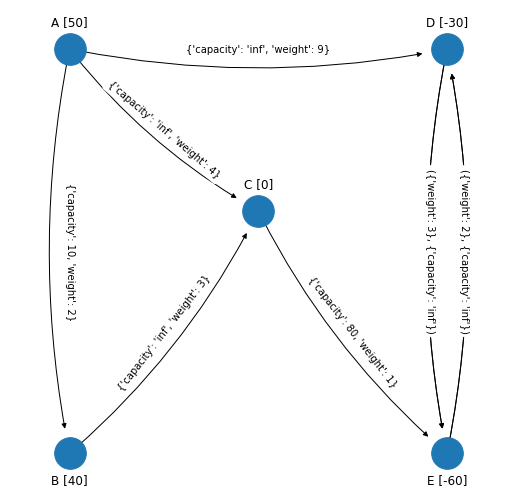

In [12]:
nodes_pos = [[0.18181818181818182, 0.7272727272727273],
             [0.18181818181818182, 0.2727272727272727],
             [0.5454545454545454, 0.2727272727272727],
             [0.5454545454545454, 0.7272727272727273],
             [0.36363636363636365, 0.5454545454545454]]

nodes = ['A', 'B', 'E', 'D', 'C']

nodes_and_pos = dict(zip(nodes, nodes_pos))

G_min_cost_flow = nx.DiGraph()

G_min_cost_flow.add_node('A', netflow = 50,  node_and_netflow="A [50]")
G_min_cost_flow.add_node('B', netflow = 40,  node_and_netflow="B [40]")
G_min_cost_flow.add_node('C', netflow = 0,   node_and_netflow="C [0]")
G_min_cost_flow.add_node('D', netflow = -30, node_and_netflow="D [-30]")
G_min_cost_flow.add_node('E', netflow = -60, node_and_netflow="E [-60]")

edge_labels_min_cost_flow = {('A', 'B'): {"weight": 2, "capacity": 10},
                             ('A', 'C'): {"weight": 4, "capacity": "inf"},
                             ('A', 'D'): {"weight": 9, "capacity": "inf"},
                             ('B', 'C'): {"weight": 3, "capacity": "inf"},
                             ('C', 'E'): {"weight": 1, "capacity": 80},
                             ('E', 'D'): {"weight": 2, "capacity": "inf"},
                             ('D', 'E'): {"weight": 3, "capacity": "inf"}
                            }


G_min_cost_flow.add_edges_from(edge_labels_min_cost_flow)
for e in G_min_cost_flow.edges():
    G_min_cost_flow[e[0]][e[1]]["capacity"] = edge_labels_min_cost_flow[e]["capacity"]
    G_min_cost_flow[e[0]][e[1]]["weight"] = edge_labels_min_cost_flow[e]["weight"]


n1 = G_min_cost_flow['E']['D']
n2 = G_min_cost_flow['D']['E']

n1["weight"] = 2
n1["capacity"] = "inf"

n2["weight"] = 3
n2["capacity"]= "inf"


stri1 = f'{({"weight": n1["weight"]},{"capacity": n1["capacity"]},)}'
stri2 = f'\n\n\n'
stri3 = f'{({"weight": n2["weight"]}, {"capacity": n2["capacity"]},)}'
string_for_edges_trouble_to_visualize_min_cost_flow = {('D', 'E'): ''.join([stri1, stri2, stri3])}

list_of_edges_trouble_to_visualize_min_cost_flow = [('D', 'E'), ('E', 'D')]
    
node_labels_min_cost_flow = nx.get_node_attributes(G_min_cost_flow, "node_and_netflow")

nodes_pos_modified = {}

y_off = 0.03

nodes_and_pos_modified = copy.deepcopy(nodes_and_pos)

for node in G_min_cost_flow.nodes():
    if node == 'B' or node == 'E':
        nodes_and_pos_modified[node] =  [nodes_and_pos_modified[node][0], 
                                         nodes_and_pos_modified[node][1] - y_off]
    else:
        nodes_and_pos_modified[node] =  [nodes_and_pos_modified[node][0], 
                                         nodes_and_pos_modified[node][1] + y_off]
        

figsize_tuple = (9, 9)
plot_graph_with_edges_trouble_to_visualize(figsize_tuple,
                                           G_min_cost_flow, nodes_and_pos,
                                           nodes_and_pos_modified,
                                           node_labels_min_cost_flow,
                                           string_for_edges_trouble_to_visualize_min_cost_flow,
                                           list_of_edges_trouble_to_visualize_min_cost_flow)

Reescribiendo en forma matricial:

$$ \min 2 x_{AB} + 4 x_{AC} + 9 x_{AD} + 3 x_{BC} + x_{CE} + 3 x_{DE} + 2x_{ED}$$

$$\text{sujeto a: }$$
$$
\begin{eqnarray}
&x_{AB}&  + &x_{AC}& + &x_{AD}&   &&         &&         &&         &&       &=& 50 \nonumber \\
&-x_{AB}&   &&         &&       + &x_{BC}&   &&         &&         &&       &=& 40 \nonumber \\
&&        - &x_{AC}&   &&       - &x_{BC}& + &x_{CE}&   &&         &&       &=& 0 \nonumber \\
&&          &&       - &x_{AD}&   &&         &&       + &x_{DE}& - &x_{ED}& &=& -30 \nonumber \\
&&          &&         &&         &&       - &x_{CE}& - &x_{DE}& + &x_{ED}& &=& -60 \nonumber
\end{eqnarray}
$$

### Resolviendo con nuestro paquete:

In [9]:
n_var_net = 7
n_cons_net = 7

In [10]:
net = create_matrix(n_var_net, n_cons_net)
constrain(net,'1,1,1,0,0,0,0,E,50')
constrain(net,'-1,0,0,1,0,0,0,E,40')
constrain(net,'0,-1,0,-1,1,0,0,E,0')
constrain(net,'0,0,-1,0,0,1,-1,E,-30')
constrain(net,'0,0,0,0,-1,-1,1,E,-60')
constrain(net,'1,0,0,0,0,0,0,L,10')
constrain(net,'0,0,0,0,1,0,0,L,80')
obj(net,'2,4,9,3,1,3,2,0')
print(net)
print(minz(net))

[[  1.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.  50.]
 [ -1.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.  40.]
 [  0.  -1.   0.  -1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.  -1.   0.   0.   1.  -1.   0.   0.   0.   0.   0.   0.   0.
    0. -30.]
 [  0.   0.   0.   0.  -1.  -1.   1.   0.   0.   0.   0.   0.   0.   0.
    0. -60.]
 [  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.
    0.  10.]
 [  0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   1.
    0.  80.]
 [ -2.  -4.  -9.  -3.  -1.  -3.  -2.   0.   0.   0.   0.   0.   0.   0.
    1.   0.]]
{'x1': 0, 'x2': 40.0, 'x3': 10.0, 'x4': 40.0, 'x5': 80.0, 'x6': 0, 'x7': 20.0, 'min': 490.0}


### Resolviendo con `linprog` del paquete **`scipy`**:

In [13]:
c_net = [2,4,9,3,1,3,2]
A_ub_net = [[1,0,0,0,0,0,0],
            [0,0,0,0,1,0,0]]
b_ub_net = [10,80]
A_eq_net = [[1,1,1,0,0,0,0],
         [-1,0,0,1,0,0,0],
         [0,-1,0,-1,1,0,0],
         [0,0,-1,0,0,1,-1],
         [0,0,0,0,-1,-1,1]]
b_eq_net = [50,40,0,-30,-60]
res_net = linprog(c_net, A_ub = A_ub_net, b_ub = b_ub_net, A_eq = A_eq_net, b_eq = b_eq_net)
print(res_net)

     con: array([ 1.90228356e-07,  1.61896459e-07,  4.04727984e-09, -1.17374949e-07,
       -2.38797142e-07])
     fun: 489.99999837231917
 message: 'Optimization terminated successfully.'
     nit: 6
   slack: array([9.99999994e+00, 3.92003230e-07])
  status: 0
 success: True
       x: array([6.25611956e-08, 3.99999997e+01, 1.00000000e+01, 3.99999999e+01,
       7.99999996e+01, 1.51241040e-08, 1.99999999e+01])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  # This is added back by InteractiveShellApp.init_path()


### Imprimiendo la red solución:

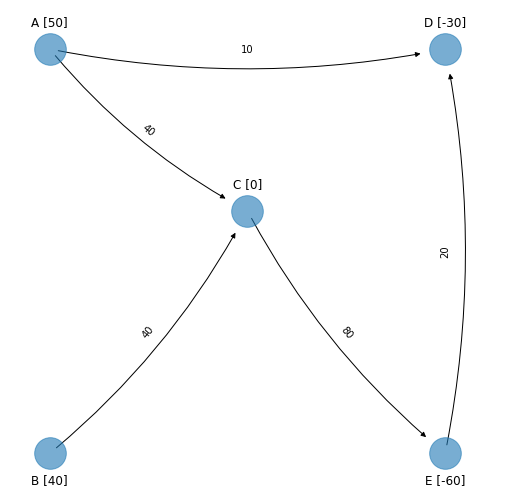

In [14]:
G_min_cost_flow_solution = nx.DiGraph()

G_min_cost_flow_solution.add_node('A', netflow = 50,  node_and_netflow="A [50]")
G_min_cost_flow_solution.add_node('B', netflow = 40,  node_and_netflow="B [40]")
G_min_cost_flow_solution.add_node('C', netflow = 0,   node_and_netflow="C [0]")
G_min_cost_flow_solution.add_node('D', netflow = -30, node_and_netflow="D [-30]")
G_min_cost_flow_solution.add_node('E', netflow = -60, node_and_netflow="E [-60]")

edge_flows = {('A', 'C'): 40,
              ('A', 'D'): 10,
              ('B', 'C'): 40,
              ('C', 'E'): 80,            
              ('E', 'D'): 20
              }

G_min_cost_flow_solution.add_edges_from(edge_flows)
node_labels_min_cost_flow_solution = nx.get_node_attributes(G_min_cost_flow_solution, "node_and_netflow")

figsize_tuple = (9, 9)
plot_graph(figsize_tuple, G_min_cost_flow_solution,
           nodes_and_pos,
           nodes_and_pos_modified,
           node_labels_min_cost_flow_solution,
           edge_flows)

Podemos ver que obtenemos los mismos resultados con nuestro paquete, utilizando `linprog` del paquete **`scipy`**, o con el algoritmo utilizado en las notas del Libro de Optimización.